In [ ]:
%pip install pandas
%pip install heartpy
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import heartpy as hp
import numpy as np

In [ ]:
BASE_DIR     = "/Users/feyzawolf/Desktop/Study data"
VR_SHIM_DIR  = os.path.join(BASE_DIR, "360-VR Data", "360 VR Shimmer")
AUD_SHIM_DIR = os.path.join(BASE_DIR, "Audio-Only Data", "Audio Only Shimmer")
BOUND_PATH = os.path.join("Study data", "condition_boundaries.csv")
df_bounds = pd.read_csv(BOUND_PATH, dtype={"ID": str})

df_bounds = pd.read_csv(BOUND_PATH, dtype={"ID": str})
df_bounds["ID"] = df_bounds["ID"].str.zfill(3)

TAGS      = ["baseline", "stress", "relaxation"]
segments  = {}

print(f"Found {len(df_bounds)} participants in boundaries table\n")  

for _, row in df_bounds.iterrows():
    pid = row["ID"]
    num = int(pid)
    shim_base = VR_SHIM_DIR if 31 <= num <= 60 else AUD_SHIM_DIR

   
    shimmer_csv = None
    for root, _, files in os.walk(shim_base):
        if f"ID{pid}" in root:
            for fn in files:
                if fn.lower().endswith(".csv"):
                    shimmer_csv = os.path.join(root, fn)
                    break
        if shimmer_csv:
            break

    if not shimmer_csv:
        print(f"⚠️  No Shimmer CSV found for ID{pid}, skipping")
        continue

    df = pd.read_csv(shimmer_csv, skiprows=[0,2])
    df.columns = df.columns.str.strip()
    ts_col  = next(c for c in df.columns if "TimestampSync" in c)
    ppg_col = next(c for c in df.columns if "PPG" in c)
    df[ts_col] = df[ts_col].astype(float).astype(int)

    segments[pid] = {}
    for tag in TAGS:
        t0, t1 = int(row[f"{tag}_start"]), int(row[f"{tag}_end"])
        seg = df[(df[ts_col] >= t0) & (df[ts_col] <= t1)].copy()
        seg["time_s"] = (seg[ts_col] - t0) / 1000.0
        segments[pid][tag] = seg[["time_s", ppg_col]].rename(columns={ppg_col: "ppg"})

print(f"\nDone slicing. Collected segments for {len(segments)} participants.")


Found 58 participants in boundaries table


Done slicing. Collected segments for 58 participants.


In [ ]:
import pandas as pd

cleaned_segments = {}
report = []

for pid, conds in segments.items():
    cleaned_segments[pid] = {}
    for cond, df in conds.items():
        df = df.copy().reset_index(drop=True)
        ppg = df['ppg']
        
        
        low_q, high_q = ppg.quantile([0.005, 0.995])
        
        
        n_below = (ppg < low_q).sum()
        n_above = (ppg > high_q).sum()
        
       
        df['ppg'] = ppg.clip(lower=low_q, upper=high_q)
        
        cleaned_segments[pid][cond] = df
        
        report.append({
            'ID':        pid,
            'condition': cond,
            'low_q':     low_q,
            'high_q':    high_q,
            'n_below':   int(n_below),
            'n_above':   int(n_above),
            'length':    len(ppg)
        })

df_report = pd.DataFrame(report)
df_report


,ID,condition,low_q,high_q,n_below,n_above,length
0,031,baseline,902.036630,2794.871795,119,69,23629
1,031,stress,916.483516,2790.476190,529,525,106552
2,031,relaxation,998.534799,2416.117216,1508,1514,303099
3,032,baseline,989.831502,2313.553114,120,119,23825
4,032,stress,893.040293,2527.472527,542,544,109227
...,...,...,...,...,...,...,...
169,089,stress,719.413919,2794.871795,464,50,93831
170,089,relaxation,821.245421,2793.406593,1572,975,316754
171,090,baseline,848.351648,2794.139194,117,43,24784
172,090,stress,837.362637,2794.139194,522,107,104645


In [ ]:
import pandas as pd
import heartpy as hp
from heartpy.peakdetection import BadSignalWarning
import warnings

warnings.simplefilter('ignore', UserWarning)

results = []
for pid, cond_dict in cleaned_segments.items():          
    for condition, seg in cond_dict.items():
        if seg.empty:
            continue
        try:
            wd, metrics = hp.process(
                seg["ppg"].values,
                sample_rate=200.0,
                calc_freq=True
            )
        except BadSignalWarning:
            continue
        except Exception:
            continue

        results.append({
            "ID": pid,
            "condition": condition,
            "mean_hr_bpm": metrics["bpm"],
            "sdnn":        metrics["sdnn"],
            "rmssd":       metrics["rmssd"],
            "pnn50":       metrics["pnn50"],
            "lf_hf_ratio": metrics.get("lf/hf", pd.NA),
            "data_points": len(seg),
            "duration_s":  seg["time_s"].iloc[-1]
        })

df_results = pd.DataFrame(results)
df_results  

df_results.to_csv("/Users/feyzawolf/Desktop/Study data/heartpy_condition_summary_clipped.csv", index=False)
print("Metrics on clipped segments written to CSV")


Metrics on clipped segments written to CSV


🔹 H1 – Heart Rate Drop (Stress → Relaxation) between groups
t = -0.730, p = 0.469

🔹 H1 – RMSSD Gain (Stress → Relaxation) between groups
t = 2.471, p = 0.017

🔎 Within-group t-tests (exploratory):

VR Group:
 - HR stress → relaxation: TtestResult(statistic=0.14412447272622503, pvalue=0.8865577101807027, df=25)
 - RMSSD stress → relaxation: TtestResult(statistic=-2.292794307057849, pvalue=0.03054632822115668, df=25)

Audio Group:
 - HR stress → relaxation: TtestResult(statistic=3.1266403829901446, pvalue=0.004445146477021909, df=25)
 - RMSSD stress → relaxation: TtestResult(statistic=1.0260211214370125, pvalue=0.31470740926884744, df=25)


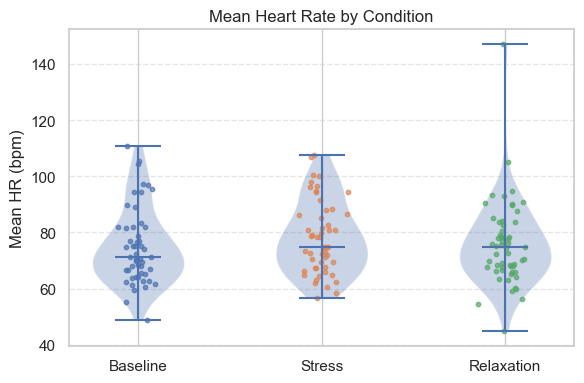

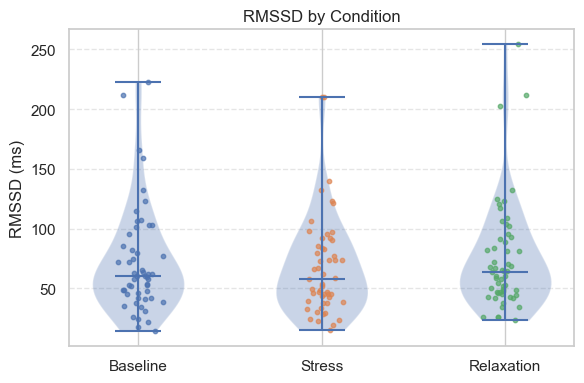

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/Users/feyzawolf/Desktop/Study data/heartpy_condition_summary_clipped.csv")


def assign_group(pid):
    pid = int(pid)
    if 31 <= pid <= 60:
        return 'VR'
    elif 61 <= pid <= 90:
        return 'Audio'
    else:
        return np.nan

df['group'] = df['ID'].astype(str).str.zfill(3).apply(assign_group)


df_wide = df.pivot(index='ID', columns='condition', values=['mean_hr_bpm', 'rmssd'])
df_wide = df_wide.dropna() 


df_wide.columns = ['_'.join(col) for col in df_wide.columns]
df_wide['group'] = df_wide.index.map(lambda x: assign_group(x))


df_wide['bpm_drop'] = df_wide['mean_hr_bpm_stress'] - df_wide['mean_hr_bpm_relaxation']
df_wide['rmssd_gain'] = df_wide['rmssd_relaxation'] - df_wide['rmssd_stress']


bpm_ttest = ttest_ind(df_wide[df_wide.group == 'VR']['bpm_drop'],
                      df_wide[df_wide.group == 'Audio']['bpm_drop'])

rmssd_ttest = ttest_ind(df_wide[df_wide.group == 'VR']['rmssd_gain'],
                        df_wide[df_wide.group == 'Audio']['rmssd_gain'])

print("H1 – Heart Rate Drop (Stress → Relaxation) between groups")
print(f"t = {bpm_ttest.statistic:.3f}, p = {bpm_ttest.pvalue:.3f}")

print("\nH1 – RMSSD Gain (Stress → Relaxation) between groups")
print(f"t = {rmssd_ttest.statistic:.3f}, p = {rmssd_ttest.pvalue:.3f}")


print("\nWithin-group t-tests (exploratory):\n")


vr = df_wide[df_wide.group == 'VR']
print("VR Group:")
print(" - HR stress → relaxation:", ttest_rel(vr['mean_hr_bpm_stress'], vr['mean_hr_bpm_relaxation']))
print(" - RMSSD stress → relaxation:", ttest_rel(vr['rmssd_stress'], vr['rmssd_relaxation']))


audio = df_wide[df_wide.group == 'Audio']
print("\nAudio Group:")
print(" - HR stress → relaxation:", ttest_rel(audio['mean_hr_bpm_stress'], audio['mean_hr_bpm_relaxation']))
print(" - RMSSD stress → relaxation:", ttest_rel(audio['rmssd_stress'], audio['rmssd_relaxation']))


df_plot = df[df['condition'].isin(['baseline', 'stress', 'relaxation'])].copy()


df = pd.read_csv("/Users/feyzawolf/Desktop/Study data/heartpy_condition_summary_clipped.csv")


conds  = ['baseline', 'stress', 'relaxation']
colors = {'baseline':'C0', 'stress':'C1', 'relaxation':'C2'}


data = [df[df['condition'] == c]['mean_hr_bpm'].values for c in conds]


plt.figure(figsize=(6, 4))
v = plt.violinplot(data, showmedians=True)
for pc in v['bodies']:
    pc.set_alpha(0.3)

for i, c in enumerate(conds):
    y = data[i]
    x = np.random.normal(loc=i+1, scale=0.05, size=len(y))
    plt.scatter(x, y, s=10, alpha=0.7, color=colors[c], label=c.capitalize() if i==0 else "")

plt.xticks([1, 2, 3], [c.capitalize() for c in conds])
plt.title("Mean Heart Rate by Condition")
plt.ylabel("Mean HR (bpm)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

data = [df[df['condition'] == c]['rmssd'].values for c in conds]


plt.figure(figsize=(6, 4))
v = plt.violinplot(data, showmedians=True)
for pc in v['bodies']:
    pc.set_alpha(0.3)

for i, c in enumerate(conds):
    y = data[i]
    x = np.random.normal(loc=i+1, scale=0.05, size=len(y))
    plt.scatter(x, y, s=10, alpha=0.7, color=colors[c], label=c.capitalize() if i==0 else "")

plt.xticks([1, 2, 3], [c.capitalize() for c in conds])
plt.title("RMSSD by Condition")
plt.ylabel("RMSSD (ms)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd


labels_pre = pd.read_csv("/Users/feyzawolf/Desktop/labels_Psylaris VR | pre-intervention_31.03-15.04.csv", header=None)
values_pre = pd.read_csv("/Users/feyzawolf/Desktop/values_Psylaris VR | pre-intervention_31.03-15.04.csv", header=None)
labels_post = pd.read_csv("/Users/feyzawolf/Desktop/labels_Psylaris VR | post-intervention_31.03-15.04.csv", header=None)
values_post = pd.read_csv("/Users/feyzawolf/Desktop/values_Psylaris VR | post-intervention_31.03-15.04.csv", header=None)


values_pre.columns = labels_pre.iloc[0].values
values_post.columns = labels_post.iloc[0].values


values_post = values_post.loc[:, ~values_post.columns.duplicated()]
values_post['participant_ID'] = values_post['participant_ID'].astype(str).str.zfill(3)

raw_cols = ['Q1_1', 'Q3_1', 'Q5_1'] + [f'Questions_{i}' for i in range(1, 11)]
seen = set()
selected_cols = [col for col in values_pre.columns if col in raw_cols and not (col in seen or seen.add(col))]

pre_data = values_pre[selected_cols].copy()


pre_data.insert(0, 'participant_ID', values_post['participant_ID'])

pre_data = pre_data.loc[:, ~pre_data.columns.duplicated()]
pre_data = pre_data.iloc[:, :14]


pre_data.columns = ['participant_ID', 'VAS_pre', 'arousal_pre', 'valence_pre'] + [f'RSQ_{i}_pre' for i in range(1, 11)]


post_data = values_post[[
    'participant_ID',
    'Q297_1', 'Q3_1', 'Q5_1',
    'RSQ_1', 'RSQ_2', 'RSQ_3', 'RSQ_4', 'RSQ_5',
    'RSQ_6', 'RSQ_7', 'RSQ_8', 'RSQ_9', 'RSQ_10'
]].copy()

post_data.columns = ['participant_ID', 'VAS_post', 'arousal_post', 'valence_post'] + [f'RSQ_{i}_post' for i in range(1, 11)]


merged_rsq = pd.merge(pre_data, post_data, on='participant_ID', how='inner')


merged_rsq.head()


,participant_ID,VAS_pre,arousal_pre,valence_pre,RSQ_1_pre,RSQ_2_pre,RSQ_3_pre,RSQ_4_pre,RSQ_5_pre,RSQ_6_pre,...,RSQ_1_post,RSQ_2_post,RSQ_3_post,RSQ_4_post,RSQ_5_post,RSQ_6_post,RSQ_7_post,RSQ_8_post,RSQ_9_post,RSQ_10_post
0,participant_ID,Q1_1,Q3_1,Q5_1,Questions_1,Questions_2,Questions_3,Questions_4,Questions_5,Questions_6,...,RSQ_1,RSQ_2,RSQ_3,RSQ_4,RSQ_5,RSQ_6,RSQ_7,RSQ_8,RSQ_9,RSQ_10
1,Please enter your participant ID,VAS scale,Level of arousal,Level of pleasure,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...,Below you will find a series of statements. Pl...
2,"{""ImportId"":""QID64_TEXT""}","{""ImportId"":""QID1217535322_1""}","{""ImportId"":""QID1217577156_1""}","{""ImportId"":""QID1217577158_1""}","{""ImportId"":""QID1217535035_1""}","{""ImportId"":""QID1217535035_2""}","{""ImportId"":""QID1217535035_3""}","{""ImportId"":""QID1217535035_4""}","{""ImportId"":""QID1217535035_5""}","{""ImportId"":""QID1217535035_6""}",...,"{""ImportId"":""QID1217477780_1""}","{""ImportId"":""QID1217477780_2""}","{""ImportId"":""QID1217477780_3""}","{""ImportId"":""QID1217477780_4""}","{""ImportId"":""QID1217477780_5""}","{""ImportId"":""QID1217477780_6""}","{""ImportId"":""QID1217477780_7""}","{""ImportId"":""QID1217477780_8""}","{""ImportId"":""QID1217477780_9""}","{""ImportId"":""QID1217477780_10""}"
3,031,4.2,22,78,2,2,4,3,5,2,...,3,3,4,2,4,3,3,4,3,1
4,032,2,32,73,3,4,3,3,2,3,...,2,2,2,4,4,3,4,4,4,2


In [ ]:

merged_rsq = merged_rsq.iloc[3:].copy()

numeric_cols = merged_rsq.columns.drop('participant_ID')
merged_rsq[numeric_cols] = merged_rsq[numeric_cols].apply(pd.to_numeric, errors='coerce')

merged_rsq = merged_rsq.reset_index(drop=True)

merged_rsq.head()


,participant_ID,VAS_pre,arousal_pre,valence_pre,RSQ_1_pre,RSQ_2_pre,RSQ_3_pre,RSQ_4_pre,RSQ_5_pre,RSQ_6_pre,...,RSQ_1_post,RSQ_2_post,RSQ_3_post,RSQ_4_post,RSQ_5_post,RSQ_6_post,RSQ_7_post,RSQ_8_post,RSQ_9_post,RSQ_10_post
0,031,4.2,22.0,78.0,2.0,2.0,4.0,3.0,5.0,2.0,...,3,3,4,2,4,3,3,4,3,1
1,032,2.0,32.0,73.0,3.0,4.0,3.0,3.0,2.0,3.0,...,2,2,2,4,4,3,4,4,4,2
2,033,1.9,62.0,77.0,3.0,3.0,2.0,4.0,4.0,3.0,...,2,2,4,4,2,4,4,4,4,2
3,034,6.1,75.0,88.0,5.0,5.0,4.0,2.0,3.0,1.0,...,1,1,2,5,2,5,5,4,2,3
4,035,1.1,78.0,96.0,2.0,3.0,1.0,3.0,1.0,2.0,...,2,2,1,4,4,4,4,4,2,2


In [ ]:
reverse_items = ['RSQ_1', 'RSQ_2', 'RSQ_3', 'RSQ_10']

for item in reverse_items:
    merged_rsq[f'{item}_pre'] = 6 - merged_rsq[f'{item}_pre']
    merged_rsq[f'{item}_post'] = 6 - merged_rsq[f'{item}_post']


In [ ]:
pq_cols = [col for col in values_post.columns if str(col).startswith("PQ_Q")]

presence_df = values_post[['participant_ID'] + pq_cols].copy()
presence_df['participant_ID'] = presence_df['participant_ID'].astype(str).str.zfill(3)

presence_df[pq_cols] = presence_df[pq_cols].apply(pd.to_numeric, errors='coerce')

presence_df['presence_score'] = presence_df[pq_cols].mean(axis=1)

presence_clean = presence_df[['participant_ID', 'presence_score']].copy()

presence_clean = presence_clean.iloc[3:].copy()


presence_clean = presence_clean.reset_index(drop=True)

presence_clean.head()


,participant_ID,presence_score
0,031,3.785714
1,032,4.142857
2,033,4.357143
3,034,3.714286
4,035,3.714286


In [ ]:
merged_rsq['participant_ID'] = merged_rsq['participant_ID'].astype(str).str.zfill(3)

merged_rsq = merged_rsq[merged_rsq['participant_ID'].between('031', '090')]

merged_rsq = merged_rsq[~merged_rsq['participant_ID'].isin(['041', '076'])]

def assign_group(pid):
    num = int(pid)
    if 31 <= num <= 60:
        return 'VR'
    elif 61 <= num <= 90:
        return 'Audio'

merged_rsq['group'] = merged_rsq['participant_ID'].apply(assign_group)

merged_rsq['group'].value_counts()


group
VR       29
Audio    29
Name: count, dtype: int64

In [ ]:

merged_rsq['RSQ_total_pre'] = merged_rsq[[f'RSQ_{i}_pre' for i in range(1, 11)]].sum(axis=1)
merged_rsq['RSQ_total_post'] = merged_rsq[[f'RSQ_{i}_post' for i in range(1, 11)]].sum(axis=1)


merged_rsq['delta_vas'] = merged_rsq['VAS_post'] - merged_rsq['VAS_pre']
merged_rsq['delta_rsq'] = merged_rsq['RSQ_total_post'] - merged_rsq['RSQ_total_pre']
merged_rsq['delta_valence'] = merged_rsq['valence_post'] - merged_rsq['valence_pre']
merged_rsq['delta_arousal'] = merged_rsq['arousal_post'] - merged_rsq['arousal_pre']

merged_rsq[['participant_ID', 'group', 'delta_vas', 'delta_rsq', 'delta_valence', 'delta_arousal']].head()


,participant_ID,group,delta_vas,delta_rsq,delta_valence,delta_arousal
0,031,VR,-1.2,3.0,-17.0,-1.0
1,032,VR,-0.1,12.0,6.0,-10.0
2,033,VR,1.1,1.0,3.0,-13.0
3,034,VR,-5.9,19.0,8.0,-66.0
4,035,VR,-0.1,13.0,-16.0,-65.0


In [ ]:
from scipy.stats import ttest_ind

vr_vas = vr['delta_vas'].dropna()
audio_vas = audio['delta_vas'].dropna()
vr_rsq = vr['delta_rsq'].dropna()
audio_rsq = audio['delta_rsq'].dropna()

t_vas = ttest_ind(vr_vas, audio_vas, equal_var=False)
t_rsq = ttest_ind(vr_rsq, audio_rsq, equal_var=False)

print("H1: Stress Reduction (VAS)")
print(f"t = {t_vas.statistic:.3f}, p = {t_vas.pvalue:.3f}")

print("\nH1: Relaxation Increase (RSQ)")
print(f"t = {t_rsq.statistic:.3f}, p = {t_rsq.pvalue:.3f}")


H1: Stress Reduction (VAS)
t = 0.315, p = 0.754

H1: Relaxation Increase (RSQ)
t = 0.935, p = 0.355


In [ ]:
vr_val = vr['delta_valence'].dropna()
audio_val = audio['delta_valence'].dropna()
vr_ar = vr['delta_arousal'].dropna()
audio_ar = audio['delta_arousal'].dropna()


t_val = ttest_ind(vr_val, audio_val, equal_var=False)
t_ar = ttest_ind(vr_ar, audio_ar, equal_var=False)

print("H2: Valence Increase (Pleasure)")
print(f"t = {t_val.statistic:.3f}, p = {t_val.pvalue:.3f}")

print("\nH2: Arousal Decrease (Calmness)")
print(f"t = {t_ar.statistic:.3f}, p = {t_ar.pvalue:.3f}")


H2: Valence Increase (Pleasure)
t = -0.835, p = 0.408

H2: Arousal Decrease (Calmness)
t = -0.233, p = 0.817


In [ ]:
from scipy.stats import pearsonr

vr_presence = pd.merge(vr, presence_clean, on='participant_ID', how='inner')

valid_vas = vr_presence[['presence_score', 'delta_vas']].dropna()
valid_rsq = vr_presence[['presence_score', 'delta_rsq']].dropna()

r_vas, p_vas = pearsonr(valid_vas['presence_score'], valid_vas['delta_vas'])

r_rsq, p_rsq = pearsonr(valid_rsq['presence_score'], valid_rsq['delta_rsq'])

print("H3: Presence vs. Stress Reduction (VAS)")
print(f"r = {r_vas:.3f}, p = {p_vas:.3f}")

print("\nH3: Presence vs. Relaxation Gain (RSQ)")
print(f"r = {r_rsq:.3f}, p = {p_rsq:.3f}")


H3: Presence vs. Stress Reduction (VAS)
r = 0.169, p = 0.399

H3: Presence vs. Relaxation Gain (RSQ)
r = -0.317, p = 0.094


/Users/feyzawolf/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:green'` for same effect.
  warnings.warn(msg, FutureWarning)


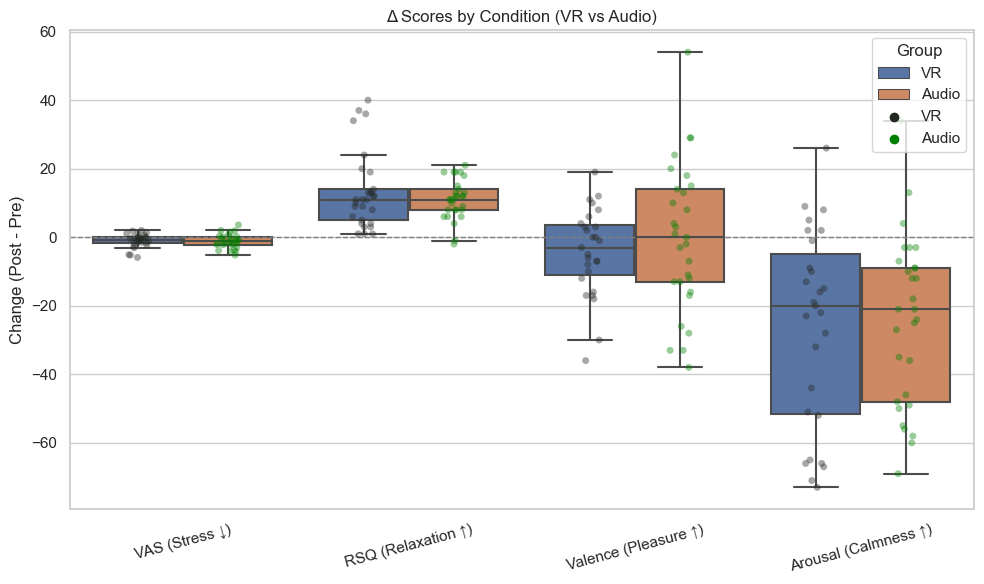

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = merged_rsq[['group', 'delta_vas', 'delta_rsq', 'delta_valence', 'delta_arousal']].melt(id_vars='group')
plot_df.columns = ['Group', 'Measure', 'Change']


label_map = {
    'delta_vas': 'VAS (Stress ↓)',
    'delta_rsq': 'RSQ (Relaxation ↑)',
    'delta_valence': 'Valence (Pleasure ↑)',
    'delta_arousal': 'Arousal (Calmness ↑)'
}
plot_df['Measure'] = plot_df['Measure'].map(label_map)


plt.figure(figsize=(10, 6))
sns.boxplot(x='Measure', y='Change', hue='Group', data=plot_df, showfliers=False)
sns.stripplot(x='Measure', y='Change', hue='Group', data=plot_df, 
              dodge=True, alpha=0.4, color='green', jitter=True)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Δ Scores by Condition (VR vs Audio)')
plt.ylabel('Change (Post - Pre)')
plt.xlabel('')
plt.xticks(rotation=15)
plt.legend(title='Group', loc='upper right')
plt.tight_layout()
plt.show()
